# Segmentace ledvin prasete domácího z CT snímků

Cílem je automaticky segmentovat zvlášť levou a zvlášť pravou ledvinu.

Odevzdání musí splňovat následující podmínky:
    
 * Kód musí být uložen a dostupný cestu na metacentru
 * Musí obsahovat soubor `run_zdo.py`
 * Musí být spustitelný:
     
         run_zdo.py vstupni_adresar vystupni_adresar


 * všechny soubory s příponou nii.gz jakkoliv vnořené ve vstupním adresáři jsou zpracovány
 * výsledky jsou ve výstupním adresáři, struktura kopíruje vstupní adresár
 * levá ledvina má příponu `.left_kidney.nii.gz` pravá má příponu `.right_kidney.nii.gz`
 * ve výstupním adresáři je rovněž adresář `visualization` ve kterém jsou 
 * Doba zpracování jednoho CT nesmí přesáhnout 30s
 
 * Kód musí být uložen na GitHub repozitář (soukromém) a vyučující do něj musí být přidán jako spolupracovník
 * Po uplynutí odevzdání bude kód zveřejněn pod MIT licencí



# Inspirace 

 * Zkuste neuronku: [Segment Anything Model](https://colab.research.google.com/drive/1PDyN7siozm25lQYpiDgUocSGMca-fx1W?usp=sharing)
 * [Afinní transformace v io3d](https://github.com/mjirik/io3d/blob/master/examples/affine_transform.ipynb)
 * [Metriky pro 3D segmentaci orgánů](https://github.com/mjirik/imma/blob/master/examples/sliver_evaluation.ipynb)

In [1]:

%load_ext autoreload
%autoreload 2


# !pip install git+https://github.com/mjirik/io3d --upgrade --force-reinstall 
# !pip install git+https://github.com/mjirik/imma --upgrade --force-reinstall 
    
!pip install git+https://github.com/mjirik/io3d 
!pip install git+https://github.com/mjirik/imma 

!pip install tqdm scikit-image loguru pydicom nibabel

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mjirik/io3d to /var/tmp/pbs.9078672.pbs-m1.metacentrum.cz/pip-req-build-s4c8xuz5
  Running command git clone --filter=blob:none --quiet https://github.com/mjirik/io3d /var/tmp/pbs.9078672.pbs-m1.metacentrum.cz/pip-req-build-s4c8xuz5
  Resolved https://github.com/mjirik/io3d to commit adcec452fdbf683990c8e8fede1835f5b0e0dfaf
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mjirik/imma to /var/tmp/pbs.9078672.pbs-m1.metacentrum.cz/pip-req-build-alsb7g9m
  Running command git clone --filter=blob:none --quiet https://github.com/mjirik/imma /var/tmp/pbs.9078672.pbs-m1.metacentrum.cz/pip-req-build-alsb7g9m
  Resolved https://github.com/mjirik/imma to commit 40bb772750dd22ba8d4d97d623ec7b846d8031ca
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-

In [2]:
from pathlib import Path
import os
import io3d
import matplotlib.pyplot as plt
import imma
import numpy as np

In [3]:
dataset_path = Path(os.environ.get("DATA_PP", default="/storage/plzen1/home/mjirik/data/biomedical/orig/pilsen_pigs_all/transplantation_nii"))
assert dataset_path.exists(), "Data not found"

# Process one 3D image

In [4]:
fn = list(dataset_path.glob("**/*.nii.gz"))[0]

In [5]:
datap = io3d.read(fn)
# size of voxel
datap.voxelsize_mm

(0.65259767, 0.65259767, 0.8)

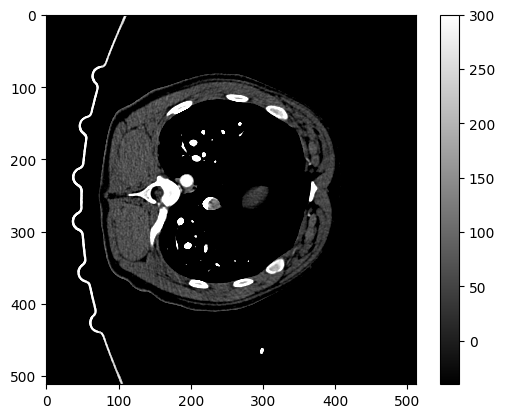

In [6]:
# show i-th slice
i = 30
plt.imshow(datap.data3d[:,:,i], cmap="gray", clim=[-40, 300])
plt.colorbar()
plt.show()

## My segmentation algorithm

In [7]:
seg = datap.data3d > 55

## Fake Ground Truth Segmentation

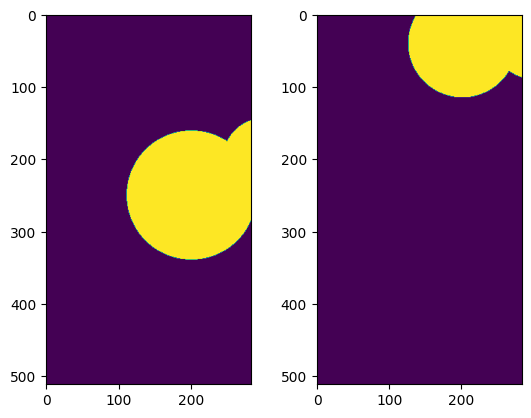

In [8]:
# fake_segmentation = np.zeros_like(dp_liver.data3d)


center = [40, 300, 200]
r = 30

sh = datap.data3d.shape
def make_sphere(r, center, shape):
    sh = shape
    xx,yy,zz = np.meshgrid(list(range(sh[0])), list(range(sh[1])), list(range(sh[2])), indexing='ij')
    fake_gt = (xx-center[0])**2 + (yy-center[1])**2 + (zz-center[2])**2 - r**2
    return fake_gt < 0

sph = make_sphere(90, [40, 250, 200], sh)
sph += make_sphere(60, [30, 200, 300], sh)

fake_gt = sph

 # fake_segmentation = skimage.morphology.ball(30)
# plt.imshow(fake_segmentation[40,:,:])
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fake_gt[50,:,:])
axs[1].imshow(fake_gt[:,200,:], aspect=datap.voxelsize_mm[0]/datap.voxelsize_mm[1])

# Evaluation

Described in paper

Heimann, T., van Ginneken, B., Styner, M. a, Arzhaeva, Y., Aurich, V., Bauer, C., … Wolf, I. (2009). Comparison and evaluation of methods for liver segmentation from CT datasets. IEEE Transactions on Medical Imaging, 28(8), 1251–1265. https://doi.org/10.1109/TMI.2009.2013851

## General metrics independent on volume type
compare_volumes(ground_true, segmentation, voxelsize_mm)

 * `volume1_mm3`: Ground True volume in [mm^3] 
 * `volume2_mm3`: Volume of segmentation in [mm^3]
 * `err1_mm3`: undersegmentation
 * `err2_mm3`: oversegmentation
 * `err1_percent`: undersegmentation in [%]
 * `err2_percent`: oversegmentation in [%]
 * `vd`: Volume difference, negative is means smaller volume of segmentation than ground true
 * `voe`: Volumetric Error
 * `avgd`: Average surface difference

In [9]:
import imma.volumetry_evaluation

In [10]:

evaluation = imma.volumetry_evaluation.compare_volumes(seg, fake_gt, voxelsize_mm = datap.voxelsize_mm)
evaluation

{'volume1_mm3': 2893184.820460975,
 'volume2_mm3': 879049.2059274316,
 'err1_mm3': 2797510.8950167894,
 'err2_mm3': 783375.2804832458,
 'err1_percent': 148.32117389573352,
 'err2_percent': 41.533758245283686,
 'vd': -69.61655544054142,
 'voe': 97.39773258651165,
 'avgd': 114.20045457398649,
 'rmsd': 16386.56987703246,
 'maxd': 297.7701488593959,
 'dice': 0.949274660705086,
 'jaccard': 0.026022674134883468}